In [ ]:
import os # provides functions for interacting with operating envrionment
from glob import glob # useful for retrive files/pathnames 
import random # implements pseudo-random number generators for various distributions.
import time # provide system time related functions
import tensorflow # tensorflow packagae for neural network modules
import datetime # The datetime module supplies classes for manipulating dates and times.


from tqdm import tqdm # gives progress bar 

import numpy as np # numpy module for scientific data calculations 
import pandas as pd # package for operting on dataframes 
from IPython.display import FileLink # Class for embedding a local file link in an IPython session, based on path
import matplotlib.pyplot as plt # datavisualization package
import warnings # to show warnings
warnings.filterwarnings('ignore') 
import seaborn as sns # datavisualization package
%matplotlib inline
from IPython.display import display, Image # display module presents Public API for display tools in IPython.
import matplotlib.image as mpimg 
import cv2 # OpenCV-Python is a library of Python bindings designed to solve computer vision problems.

from sklearn.model_selection import train_test_split # Split arrays or matrices into random train and test subsets
from sklearn.datasets import load_files   # load datasets  text files with categories as subfolder names.    
from keras.utils import np_utils # numpy utilities in keras
from sklearn.utils import shuffle # Shuffle arrays or sparse matrices in a consistent way
from sklearn.metrics import log_loss # calculates the negative log-likelihood of a logistic model that returns y_pred probabilities for its training data y_true

from keras.models import Sequential, Model # A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D # multiple hidden layers for building network graph
from keras.preprocessing.image import ImageDataGenerator # Generate batches of tensor image data with real-time data augmentation.
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint, EarlyStopping # ModelCheckpoint - to save a model or weights;  EarlyStopping- Stop training when a monitored metric has stopped improving.
from keras.applications.vgg16 import VGG16 # Keras Applications are deep learning models that  available alongside pre-trained weights which be used for prediction, feature extraction, and fine-tuning.

## Import the Datasets



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import io # The io module provides Python’s main facilities for dealing with various types of I/O
dataset = pd.read_csv('/content/drive/MyDrive/Distracted driver detetcion/Dataset/driver_imgs_list.csv') # Read a comma-separated values (csv) file into DataFrame.
dataset.head(5)

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


#### Import Driver Dataset

In [ ]:
by_drivers = dataset.groupby('subject')
unique_drivers = by_drivers.groups.keys()
print(unique_drivers)

dict_keys(['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081'])


In [ ]:

NUMBER_CLASSES = 10
# Color type: 1 - grey, 3 - rgb

def get_cv2_image(path, img_rows, img_cols, color_type=3): # function to read image input 
    if color_type == 1:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE) # to read image as grayscale 
    elif color_type == 3:
        img = cv2.imread(path, cv2.IMREAD_COLOR) # to read image as color
    # Reduce size
    img = cv2.resize(img, (img_rows, img_cols)) # resize the image to desired size 
    return img # return the processed image

# Training
def load_train(img_rows, img_cols, color_type=3): # function to load training data
    start_time = time.time() # to record time at the start of training process
    train_images = [] # creating empty list to store train images
    train_labels = [] # creating empty list to store train labels
    # Loop over the training folder 
    for classed in tqdm(range(NUMBER_CLASSES)):
        print('Loading directory c{}'.format(classed))
        files = glob(os.path.join('/content/drive/MyDrive/Distracted driver detetcion', 'Dataset', 'images','train', 'c' + str(classed), '*.jpg'))
        for file in files:
            img = get_cv2_image(file, img_rows, img_cols, color_type) # preprocess the image data according to function defined above 
            train_images.append(img) # append train images to list created
            train_labels.append(classed) # append train labels to list created
    print("Data Loaded in {} second".format(time.time() - start_time)) # estimating the time for loading data
    return train_images, train_labels # function returns train images and labesl

def read_and_normalize_train_data(img_rows, img_cols, color_type):
    X, labels = load_train(img_rows, img_cols, color_type) 
    y = np_utils.to_categorical(labels, 10) # Converts a class vector (integers) to  class matrix.
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # split loaded data into train and test in ratio 80:20
    
    x_train = np.array(x_train, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type) # forming numpy array of train data
    x_test = np.array(x_test, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type) # forming numpy array of test data
    
    return x_train, x_test, y_train, y_test

# Validation
def load_test(size=200000, img_rows=64, img_cols=64, color_type=3): # function to load test data
    path = os.path.join('/content/drive/MyDrive/Distracted driver detetcion', 'Dataset', 'images', 'test', '*.jpg')
    files = sorted(glob(path))
    X_test, X_test_id = [], []
    total = 0
    files_size = len(files)
    for file in tqdm(files):
        if total >= size or total >= files_size:
            break
        file_base = os.path.basename(file)
        img = get_cv2_image(file, img_rows, img_cols, color_type)
        X_test.append(img)
        X_test_id.append(file_base)
        total += 1
    return X_test, X_test_id

def read_and_normalize_sampled_test_data(size, img_rows, img_cols, color_type=3):
    test_data, test_ids = load_test(size, img_rows, img_cols, color_type)
    
    test_data = np.array(test_data, dtype=np.uint8)
    test_data = test_data.reshape(-1,img_rows,img_cols,color_type)
    
    return test_data, test_ids

In [ ]:
img_rows = 64
img_cols = 64
color_type = 1

In [ ]:
x_train, x_test, y_train, y_test = read_and_normalize_train_data(img_rows, img_cols, color_type)
print('Train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')

  0%|          | 0/10 [00:00<?, ?it/s]

Loading directory c0


 10%|█         | 1/10 [00:04<00:42,  4.69s/it]

Loading directory c1


 20%|██        | 2/10 [00:08<00:36,  4.52s/it]

Loading directory c2


 30%|███       | 3/10 [00:13<00:31,  4.45s/it]

Loading directory c3


 40%|████      | 4/10 [00:17<00:26,  4.43s/it]

Loading directory c4


 50%|█████     | 5/10 [00:21<00:21,  4.37s/it]

Loading directory c5


 60%|██████    | 6/10 [00:26<00:17,  4.36s/it]

Loading directory c6


 70%|███████   | 7/10 [00:30<00:13,  4.35s/it]

Loading directory c7


 80%|████████  | 8/10 [00:34<00:08,  4.17s/it]

Loading directory c8


 90%|█████████ | 9/10 [00:37<00:03,  3.97s/it]

Loading directory c9


100%|██████████| 10/10 [00:41<00:00,  4.15s/it]

Data Loaded in 41.52394104003906 second
Train shape: (17939, 64, 64, 1)
17939 train samples


In [ ]:
nb_test_samples = 200
test_files, test_targets = read_and_normalize_sampled_test_data(nb_test_samples, img_rows, img_cols, color_type)
print('Test shape:', test_files.shape)
print(test_files.shape[0], 'Test samples')

  0%|          | 200/79726 [00:00<02:05, 634.62it/s]

Test shape: (200, 64, 64, 1)
200 Test samples


#### Exploratory Data Analysis

In [ ]:
# Load the list of names
names = [item[17:19] for item in sorted(glob("/content/drive/MyDrive/Distracted driver detection/Dataset/images/train/*"))]
test_files_size = len(np.array(glob(os.path.join("/content/drive/MyDrive/Distracted driver detection/Dataset/images/test/*"))))
x_train_size = len(x_train)
categories_size = len(names)
x_test_size = len(x_test)
print('There are %s total images.\n' % (test_files_size + x_train_size + x_test_size))
print('There are %d training images.' % x_train_size)
print('There are %d total training categories.' % categories_size)
print('There are %d validation images.' % x_test_size)
print('There are %d test images.'% test_files_size)

There are 102150 total images.

There are 17939 training images.
There are 10 total training categories.
There are 4485 validation images.
There are 79726 test images.


#### Dataset Visualization

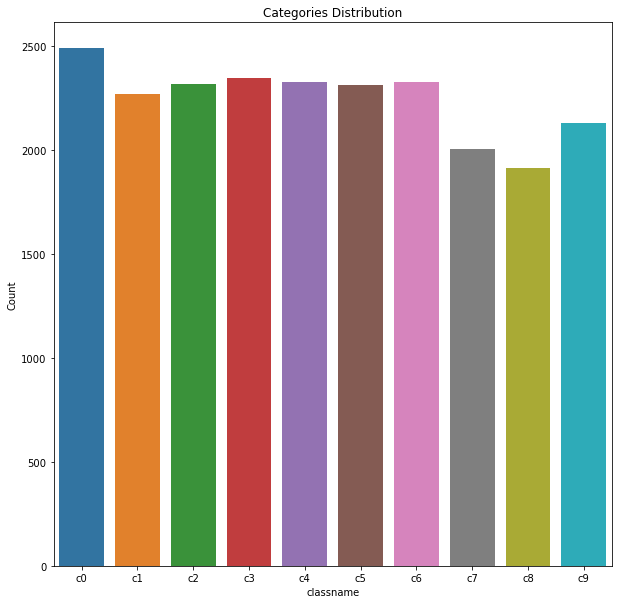

In [ ]:
# Plot figure size
plt.figure(figsize = (10,10))
# Count the number of images per category
sns.countplot(x = 'classname', data = dataset)
# Change the Axis names
plt.ylabel('Count')
plt.title('Categories Distribution')
# Show plot
plt.show()

In [ ]:
# Find the frequency of images per driver
drivers_id = pd.DataFrame((dataset['subject'].value_counts()).reset_index())
drivers_id.columns = ['driver_id', 'Counts']
drivers_id

,driver_id,Counts
0,p021,1237
1,p022,1233
2,p024,1226
3,p026,1196
4,p016,1078
5,p066,1034
6,p049,1011
7,p051,920
8,p014,876
9,p015,875


<Figure size 1440x1440 with 0 Axes>

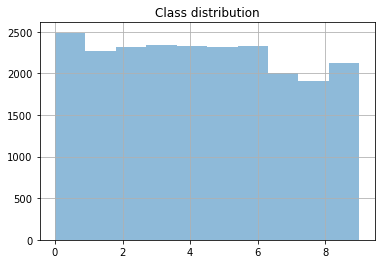

In [ ]:
# Plotting class distribution
dataset['class_type'] = dataset['classname'].str.extract('(\d)',expand=False).astype(np.float)
plt.figure(figsize = (20,20))
dataset.hist('class_type', alpha=0.5, layout=(1,1), bins=10)
plt.title('Class distribution')
plt.show()

In [ ]:
activity_map = {'c0': 'Safe driving', 
                'c1': 'Texting - right', 
                'c2': 'Talking on the phone - right', 
                'c3': 'Texting - left', 
                'c4': 'Talking on the phone - left', 
                'c5': 'Operating the radio', 
                'c6': 'Drinking', 
                'c7': 'Reaching behind', 
                'c8': 'Hair and makeup', 
                'c9': 'Talking to passenger'}

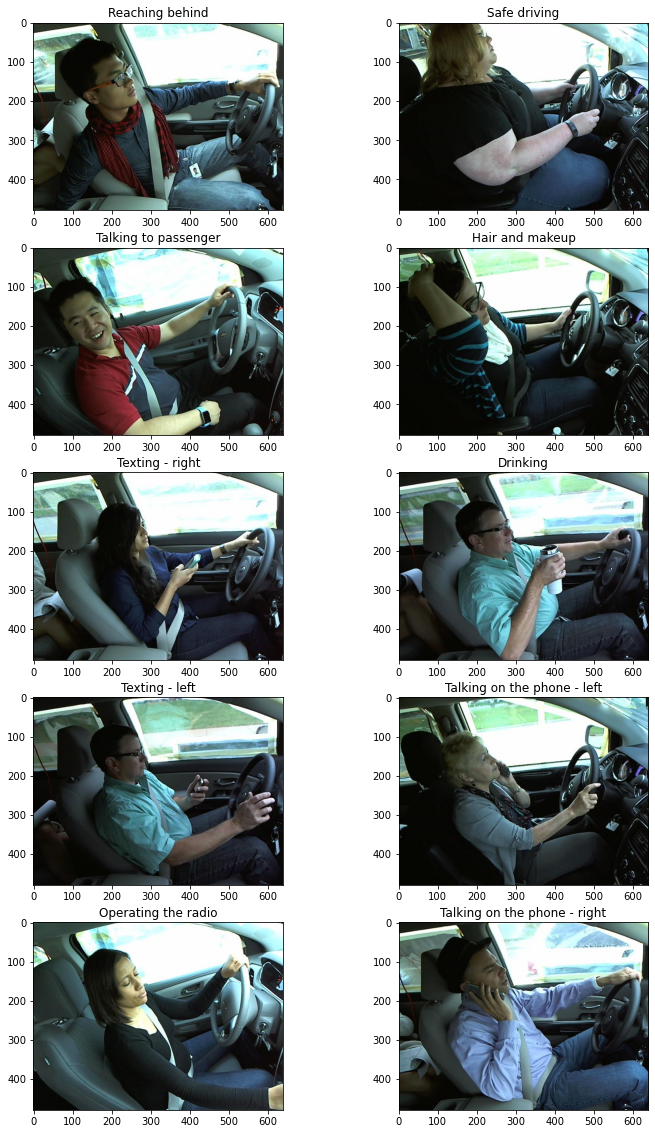

In [ ]:
plt.figure(figsize = (12, 20))
image_count = 1
BASE_URL = '/content/drive/MyDrive/Distracted driver detetcion/Dataset/images/train/'
for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(5, 2, image_count)
                image_count += 1
                image = mpimg.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(activity_map[directory])

## Vanilla CNN model

In [ ]:
models_dir = "saved_models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    
checkpointer = ModelCheckpoint(filepath='saved_models/weights_best_vanilla.hdf5', 
                               monitor='val_loss', mode='min',
                               verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
callbacks = [checkpointer, es]

In [ ]:
batch_size = 40 # defining batch size
nb_epoch = 10 # defining number of epochs for which data has to be trained

#### Model v1
---

In [ ]:
def create_model_v1():
    # Vanilla CNN model
    model = Sequential() # intializing a sequential graph model 

    model.add(Conv2D(filters = 64, kernel_size = 3, padding='same', activation = 'relu', input_shape=(img_rows, img_cols, color_type))) # a 2-D convolutional layer with 64 kernels of size 3 and relu activation function 
    model.add(MaxPooling2D(pool_size = 2)) # defining maxpooling layer of window size 2 x 2  

    model.add(Conv2D(filters = 128, padding='same', kernel_size = 3, activation = 'relu')) # convolutional 2D layer with 128 filters 
    model.add(MaxPooling2D(pool_size = 2)) # definig maxpooling layer of window size 2x2

    model.add(Conv2D(filters = 256, padding='same', kernel_size = 3, activation = 'relu'))# convolutional 2D layer with 256 filters 
    model.add(MaxPooling2D(pool_size = 2))

    model.add(Conv2D(filters = 512, padding='same', kernel_size = 3, activation = 'relu')) # convolutional 2D layer with 512 filters 
    model.add(MaxPooling2D(pool_size = 2))

    model.add(Dropout(0.5)) # dropping 50% neurons to avoid overfitting 

    model.add(Flatten()) # flatting the data before passing to output layer

    model.add(Dense(500, activation = 'relu')) # dense layer with 500 filters and relu activation function
    model.add(Dropout(0.5)) # dropping out 50% neurons to avoid overfitting
    model.add(Dense(10, activation = 'softmax')) # output layer with 10 filters corresponding to 10 classes and softmax activation
    
    return model

In [ ]:
model_v1 = create_model_v1()

# More details about the layers
model_v1.summary()

# Compiling the model
model_v1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 256)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 512)         1

In [ ]:
# Training the Vanilla Model version 1
history_v1 = model_v1.fit(x_train, y_train, 
          validation_data=(x_test, y_test),
          callbacks=callbacks,
          epochs=nb_epoch, batch_size=batch_size, verbose=1)# fitting the model with train and passing test data for validation 

Epoch 1/10
449/449 [==============================] - ETA: 0s - loss: 2.5199 - accuracy: 0.4953
Epoch 00001: val_loss improved from inf to 0.29325, saving model to saved_models/weights_best_vanilla.hdf5
449/449 [==============================] - 137s 305ms/step - loss: 2.5199 - accuracy: 0.4953 - val_loss: 0.2932 - val_accuracy: 0.9142
Epoch 2/10
449/449 [==============================] - ETA: 0s - loss: 0.3564 - accuracy: 0.8948
Epoch 00002: val_loss improved from 0.29325 to 0.14773, saving model to saved_models/weights_best_vanilla.hdf5
449/449 [==============================] - 138s 307ms/step - loss: 0.3564 - accuracy: 0.8948 - val_loss: 0.1477 - val_accuracy: 0.9648
Epoch 3/10
449/449 [==============================] - ETA: 0s - loss: 0.2363 - accuracy: 0.9376
Epoch 00003: val_loss did not improve from 0.14773
449/449 [==============================] - 137s 304ms/step - loss: 0.2363 - accuracy: 0.9376 - val_loss: 0.1634 - val_accuracy: 0.9639
Epoch 4/10
449/449 [==================

Load the classifier with the best validation loss

In [ ]:
def plot_train_history(history):
    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

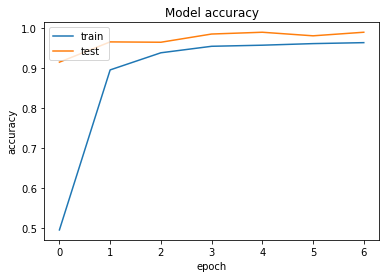

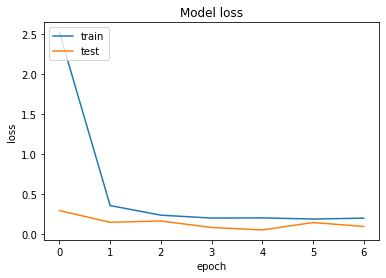

In [ ]:
plot_train_history(history_v1)

In [ ]:
def plot_test_class(model, test_files, image_number, color_type=1):
    img_brute = test_files[image_number]
    img_brute = cv2.resize(img_brute,(img_rows,img_cols))
    plt.imshow(img_brute, cmap='gray')

    new_img = img_brute.reshape(-1,img_rows,img_cols,color_type)

    y_prediction = model.predict(new_img, batch_size=batch_size, verbose=1)
    print('Y prediction: {}'.format(y_prediction))
    print('Predicted: {}'.format(activity_map.get('c{}'.format(np.argmax(y_prediction)))))
    
    plt.show()

In [ ]:
score = model_v1.evaluate(x_test, y_test, verbose=1)
print('Score: ', score)

141/141 [==============================] - 7s 53ms/step - loss: 0.0953 - accuracy: 0.9889
Score:  [0.0952872782945633, 0.9888517260551453]


1/1 [==============================] - 0s 746us/step
Y prediction: [[6.5455301e-11 2.7945939e-08 1.0000000e+00 6.1474369e-17 1.3988499e-17
  1.0492395e-14 2.4985478e-09 1.2190617e-16 1.7575087e-09 2.7083453e-15]]
Predicted: Talking on the phone - right


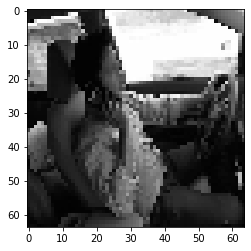

In [ ]:
plot_test_class(model_v1, test_files, 20)

#### Optimised Vanilla CNN Model 

#### Model v2
---

In [ ]:
def create_model_v2():
    # Optimised Vanilla CNN model
    model = Sequential()
    model.add(Conv2D(32,(3,3),activation='relu',input_shape=(img_rows, img_cols, color_type)))
    model.add(BatchNormalization())
    model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.3))
    model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.3))
    model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(10,activation='softmax'))

    return model

In [ ]:
model_v2 = create_model_v2()

# More details about the layers
model_v2.summary()

# Compiling the model
model_v2.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 62, 62, 32)        128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 62, 62, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 62, 62, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 31, 31, 64)       

In [ ]:
# Training the Vanilla Model
history_v2 = model_v2.fit(x_train, y_train, 
          validation_data=(x_test, y_test),
          callbacks=callbacks,
          epochs=nb_epoch, batch_size=batch_size, verbose=1)

Epoch 1/10
449/449 [==============================] - ETA: 0s - loss: 1.2292 - accuracy: 0.5928
Epoch 00001: val_loss did not improve from 0.05210
449/449 [==============================] - 185s 413ms/step - loss: 1.2292 - accuracy: 0.5928 - val_loss: 0.4827 - val_accuracy: 0.8544
Epoch 2/10
449/449 [==============================] - ETA: 0s - loss: 0.3530 - accuracy: 0.8906
Epoch 00002: val_loss did not improve from 0.05210
449/449 [==============================] - 183s 408ms/step - loss: 0.3530 - accuracy: 0.8906 - val_loss: 0.1491 - val_accuracy: 0.9605
Epoch 3/10
449/449 [==============================] - ETA: 0s - loss: 0.2120 - accuracy: 0.9351
Epoch 00003: val_loss did not improve from 0.05210
449/449 [==============================] - 184s 409ms/step - loss: 0.2120 - accuracy: 0.9351 - val_loss: 0.2427 - val_accuracy: 0.9318
Epoch 4/10
449/449 [==============================] - ETA: 0s - loss: 0.1478 - accuracy: 0.9553
Epoch 00004: val_loss did not improve from 0.05210
449/449

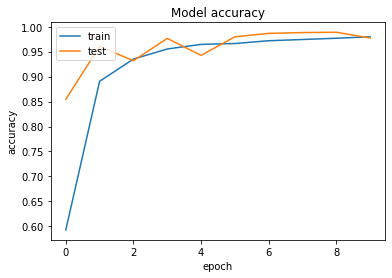

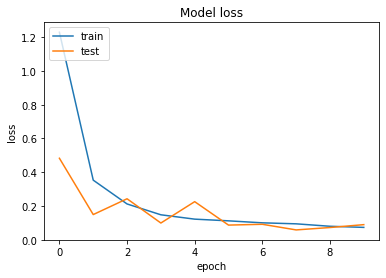

In [ ]:
plot_train_history(history_v2)


In [ ]:
score = model_v2.evaluate(x_test, y_test, verbose=1)
print('Score: ', score)

y_pred = model_v2.predict(x_test, batch_size=batch_size, verbose=1)
score = log_loss(y_test, y_pred)
print('Score log loss:', score)

141/141 [==============================] - 6s 41ms/step - loss: 0.0895 - accuracy: 0.9773
Score:  [0.08946067839860916, 0.9772575497627258]
113/113 [==============================] - 6s 50ms/step
Score log loss: 0.089460648579866


1/1 [==============================] - 0s 820us/step
Y prediction: [[7.9885485e-13 2.8062367e-23 4.8983064e-15 9.4625242e-14 5.9513872e-07
  9.9999940e-01 8.4643390e-11 3.4683534e-12 2.4438107e-10 9.0658443e-13]]
Predicted: Operating the radio


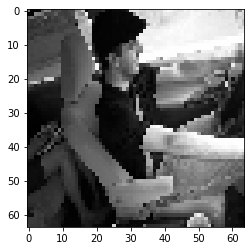

In [ ]:
plot_test_class(model_v2, test_files, 1) # The model really performs badly

1/1 [==============================] - 0s 703us/step
Y prediction: [[5.2641502e-14 1.6299181e-14 1.0039999e-19 1.0000000e+00 1.8520630e-12
  6.2616847e-16 1.9376539e-19 3.7562889e-14 8.6282175e-13 8.5554156e-15]]
Predicted: Texting - left


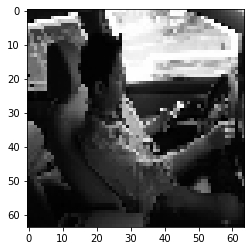

In [ ]:
plot_test_class(model_v2, test_files, 143) 

## Create a vanilla CNN model with data augmentation


In [ ]:
# Prepare data augmentation configuration
# Generate batches of tensor image data with real-time data augmentation with horizontal flipping ; 
# zoom the existing image and apply shearing transforms to image.
train_datagen = ImageDataGenerator(rescale = 1.0/255, 
                                   shear_range = 0.2, 
                                   zoom_range = 0.2, 
                                   horizontal_flip = True, 
                                   validation_split = 0.2)

test_datagen = ImageDataGenerator(rescale=1.0/ 255, validation_split = 0.2)

In [ ]:
nb_train_samples = x_train.shape[0]
nb_validation_samples = x_test.shape[0]
print(nb_train_samples)
print(nb_validation_samples)
training_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)
validation_generator = test_datagen.flow(x_test, y_test, batch_size=batch_size)

17939
4485


#### Train the model with Data Augmentation

Using `fit_generator`, I'll train the model.

In [ ]:
checkpoint = ModelCheckpoint('saved_models/weights_best_vanilla.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
# fit_generator - # Trains the model on data generated batch-by-batch by image generator
history_v3 = model_v2.fit_generator(training_generator,
                         steps_per_epoch = nb_train_samples // batch_size,
                         epochs = 5, 
                         callbacks=[es, checkpoint],
                         verbose = 1,
                         validation_data = validation_generator,
                         validation_steps = nb_validation_samples // batch_size)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
448/448 [==============================] - 175s 390ms/step - loss: 1.3772 - accuracy: 0.6108 - val_loss: 17.8554 - val_accuracy: 0.0879
Epoch 2/5
448/448 [==============================] - 173s 387ms/step - loss: 0.7181 - accuracy: 0.7647 - val_loss: 0.4548 - val_accuracy: 0.8574
Epoch 3/5
448/448 [==============================] - 175s 391ms/step - loss: 0.5386 - accuracy: 0.8283 - val_loss: 0.1409 - val_accuracy: 0.9759
Epoch 4/5
448/448 [==============================] - 183s 409ms/step - loss: 0.4516 - accuracy: 0.8612 - val_loss: 0.1457 - val_accuracy: 0.9625
Epoch 5/5
448/448 [==============================] - 186s 414ms/step - loss: 0.4026 - accuracy: 0.8779 - val_loss: 0.1340 - val_accuracy: 0.9652


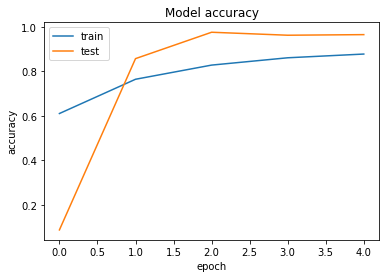

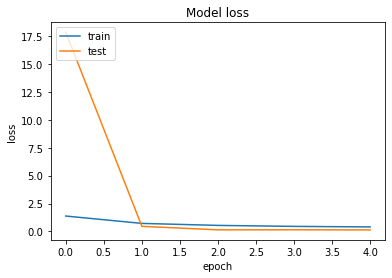

In [ ]:
plot_train_history(history_v3)

In [ ]:
# Evaluate the performance of the new model
score = model_v2.evaluate_generator(validation_generator, nb_validation_samples // batch_size)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Instructions for updating:
Please use Model.evaluate, which supports generators.
Test Score: 0.13397763669490814
Test Accuracy: 0.9651785492897034


1/1 [==============================] - 0s 615us/step
Y prediction: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
Predicted: Operating the radio


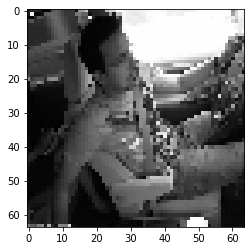

In [ ]:
plot_test_class(model_v2, test_files, 101)

1/1 [==============================] - 0s 607us/step
Y prediction: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
Predicted: Operating the radio


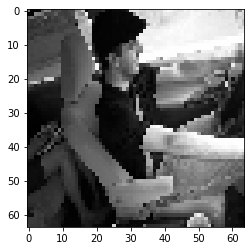

In [ ]:
plot_test_class(model_v2, test_files, 1) 

1/1 [==============================] - 0s 608us/step
Y prediction: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
Predicted: Operating the radio


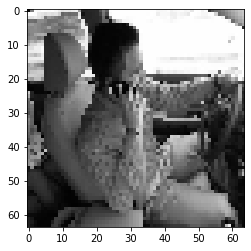

In [ ]:
plot_test_class(model_v2, test_files, 145) 

1/1 [==============================] - 0s 612us/step
Y prediction: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
Predicted: Hair and makeup


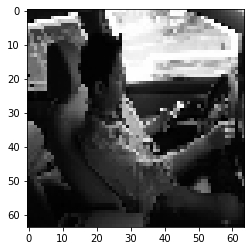

In [ ]:
plot_test_class(model_v2, test_files, 143) 